In [1]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import os
import warnings
import os, sys
import numpy as np
import keras
import pathlib
import pandas as pd
import random
from tqdm import tqdm
from PIL import Image
from skimage import io,transform
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, AlphaDropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.models import Model
from keras import layers
from keras import backend as K
from keras.applications import vgg16
from livelossplot import PlotLossesKeras

config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

KTF.set_session(session)

/hdd/home/superdanby/.conda/envs/yee/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET = pathlib.Path('CroppedYale').resolve()
FOLDERS = sorted([x for x in DATASET.iterdir() if x.is_dir()])
TRAIN_NUM = 35
IMG_SHAPE = [192, 168, 3] # height, width, channels


def load_paths(shuffle = False):
    """ Load paths """

    train_paths, train_lbls = [], []
    test_paths, test_lbls = [], []

    for i, dir_ in enumerate(tqdm(FOLDERS)):
        img_paths = dir_.glob('*.pgm')
        img_paths = [p for p in sorted(img_paths)]
        lbls = [i for _ in range(len(img_paths))]
        
        if shuffle:
            random.shuffle(img_paths)

        train_paths.extend(img_paths[:TRAIN_NUM])
        train_lbls.extend(lbls[:TRAIN_NUM])
        test_paths.extend(img_paths[TRAIN_NUM:])
        test_lbls.extend(lbls[TRAIN_NUM:])

    return train_paths, train_lbls, test_paths, test_lbls



def load_data(paths, lbls):
    """ Load data and labels."""

    # load with constant size
    # n_samples = len(paths)
    # xs = np.zeros((n_samples, 64, 64), dtype=np.float32)

    # load with dynamic size
    xs = []
    ys = np.uint8(lbls)
    for i, p in enumerate(tqdm(paths)):
        img = Image.open(p)
        npimg = []
        npimg.append(np.array(img, dtype=float))
        npimg.append(np.array(img, dtype=float))
        npimg.append(np.array(img, dtype=float))
        npimg = np.asarray(npimg)
        npimg = transform.resize(npimg, (3, 192, 168))
#         npimg = transform.resize(npimg, (3, 192, 168), anti_aliasing=True)
        npimg = np.rollaxis(npimg, 0, 3)
        assert npimg.shape == (192, 168, 3)
        xs.append(npimg)
        
        
    return np.asarray(xs), ys

In [3]:
def VGG16(input_tensor=None, input_shape=None):
    '''No use?!'''
    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)


    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fca')(x)
    x = Dense(4096, activation='relu', name='fcb')(x)
    x = Dense(12, activation='softmax', name='Classification')(x)


    # Create model.
    return Model(inputs=img_input, outputs=x, name='vgg16')

In [4]:
model = vgg16.VGG16(include_top=False, input_shape=IMG_SHAPE)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 168, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 168, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 168, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 84, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 84, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 84, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 42, 128)       0         
__________

In [5]:
model.load_weights("model.h5")


output = model.output
output = Flatten()(output)
output = Dense(256, activation='selu', kernel_initializer='lecun_normal')(output)
output = AlphaDropout(0.2)(output)
output = Dense(128, activation='selu', kernel_initializer='lecun_normal')(output)
output = AlphaDropout(0.1)(output)
output = Dense(128, activation='selu', kernel_initializer='lecun_normal')(output)
output = AlphaDropout(0.1)(output)
output = Dense(38, activation='softmax')(output)
new_model = Model(model.input, output)
new_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 168, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 168, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 168, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 84, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 84, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 84, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 42, 128)       0         
__________

In [6]:
train_paths, train_lbls, test_paths, test_lbls = load_paths(shuffle = True)
x_train, y_train = load_data(train_paths, train_lbls)
x_test, y_test = load_data(test_paths, test_lbls)

  0%|          | 0/1330 [00:00<?, ?it/s]/hdd/home/superdanby/.conda/envs/yee/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 1122/1122 [00:04<00:00, 233.46it/s]


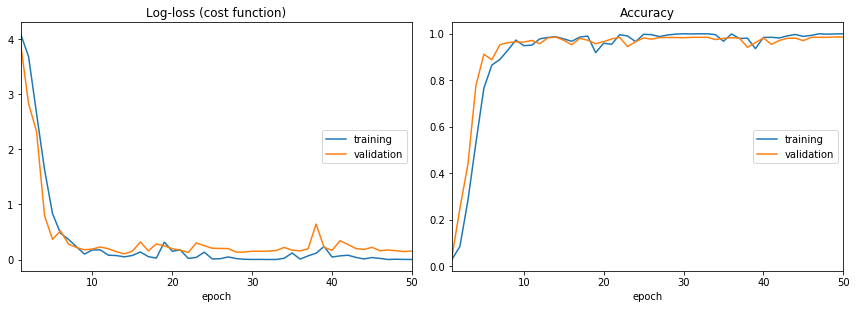

In [7]:
BATCH_SIZE=10
EPOCH=50
# EARLY=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
hist = new_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCH, shuffle=True, callbacks=[PlotLossesKeras()], verbose=0)

In [8]:
df = pd.DataFrame(hist.history)
df

,acc,loss,val_acc,val_loss
0,0.028571,4.100663,0.040107,3.924948
1,0.084962,3.687188,0.248663,2.833134
2,0.282707,2.653289,0.437611,2.324554
3,0.530075,1.634787,0.776292,0.798782
4,0.766165,0.833392,0.911765,0.367462
5,0.865414,0.478784,0.888592,0.519588
6,0.889474,0.366367,0.952763,0.279356
7,0.929323,0.232917,0.961676,0.219111
8,0.972932,0.099994,0.965241,0.176891
9,0.948872,0.174670,0.964349,0.191425


In [9]:
exit()